In [2]:
#REQUIRED LIBRARIES
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.layers import CuDNNGRU,GRU
from sklearn.preprocessing import StandardScaler
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from numpy import newaxis
from collections import Counter
from imblearn.under_sampling import TomekLinks
import os
import random
import lightgbm as gbm
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score

In [3]:
#REPRODUCABLE RESULT
seed_value= 2020
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.set_random_seed(seed_value)

In [4]:
#DATASET LOADING
training = pd.read_csv("UNSW_NB15_total_numeric_training.csv")
testing = pd.read_csv("UNSW_NB15_total_numeric_testing.csv")

x_tr = training.drop(["id","label","attack_cat"],axis=1)
y_tr = training[["attack_cat"]]
                      
x_ts = testing.drop(["id","label","attack_cat"],axis=1)
y_ts = testing[["attack_cat"]]

In [5]:
#DATASET DIVIDING FOR TESTING
x_tr_p1,x_tr_p2,y_tr_p1,y_tr_p2 = train_test_split(x_tr,y_tr,test_size=0.4,stratify=y_tr,random_state=34)

In [6]:
#LIGHTGBM FEATURE SELECTION PROCESS
start = time()
lgb_train = gbm.Dataset(x_tr_p1,y_tr_p1,
                        feature_name=['dur','proto','service','state','spkts','dpkts','sbytes','dbytes',
                                      'rate','sttl','dttl','sload','dload','sloss','dloss','sinpkt','dinpkt',
                                      'sjit','djit','swin','stcpb','dtcpb','dwin','tcprtt','synack','ackdat',
                                      'smean','dmean','trans_depth','response_body_len','ct_srv_src',
                                      'ct_state_ttl','ct_dst_ltm','ct_src_dport_ltm','ct_dst_sport_ltm',
                                      'ct_dst_src_ltm','is_ftp_login','ct_ftp_cmd','ct_flw_http_mthd',
                                      'ct_src_ltm','ct_srv_dst','is_sm_ips_ports'],
                        categorical_feature=['service','state','sttl','dttl','is_ftp_login','ct_ftp_cmd'])

lgb_eval = gbm.Dataset(x_tr_p1,y_tr_p1,reference=lgb_train)
params = {
    'task': 'train',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class':10,
    'learning_rate': 0.03,
    'verbose': 0,
    'tree_learner': 'voting',
}
evals={}
clf = gbm.train(params,lgb_train,num_boost_round=50,valid_sets=lgb_eval,evals_result=evals,early_stopping_rounds=3)
print("Training %.2f seconds:" % ((time() - start)))

/home/alper/.local/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/alper/.local/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ct_ftp_cmd', 'dttl', 'is_ftp_login', 'service', 'state', 'sttl']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/alper/.local/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's multi_logloss: 1.67279
Training until validation scores don't improve for 3 rounds.
[2]	valid_0's multi_logloss: 1.61672
[3]	valid_0's multi_logloss: 1.56584
[4]	valid_0's multi_logloss: 1.51937
[5]	valid_0's multi_logloss: 1.4763
[6]	valid_0's multi_logloss: 1.43613
[7]	valid_0's multi_logloss: 1.39796
[8]	valid_0's multi_logloss: 1.36239
[9]	valid_0's multi_logloss: 1.32849
[10]	valid_0's multi_logloss: 1.29638
[11]	valid_0's multi_logloss: 1.26585
[12]	valid_0's multi_logloss: 1.23679
[13]	valid_0's multi_logloss: 1.20909
[14]	valid_0's multi_logloss: 1.18267
[15]	valid_0's multi_logloss: 1.15749
[16]	valid_0's multi_logloss: 1.13334
[17]	valid_0's multi_logloss: 1.11028
[18]	valid_0's multi_logloss: 1.08817
[19]	valid_0's multi_logloss: 1.06702
[20]	valid_0's multi_logloss: 1.04676
[21]	valid_0's multi_logloss: 1.02722
[22]	valid_0's multi_logloss: 1.0083
[23]	valid_0's multi_logloss: 0.9901
[24]	valid_0's multi_logloss: 0.972617
[25]	valid_0's multi_logloss: 0.955819

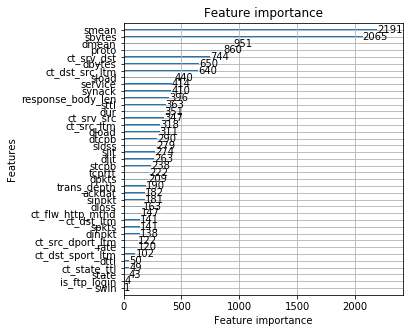

In [7]:
%matplotlib inline
gbm.plot_importance(clf,figsize=(5, 5))

In [8]:
imp=clf.feature_importance()
name=clf.feature_name()
feature_sorted=[]
for i in np.argsort(imp):
     feature_sorted.append(name[i])
feature_sorted.reverse()
f_set = feature_sorted

In [10]:
f_set[:22]

['smean',
 'sbytes',
 'dmean',
 'proto',
 'ct_srv_dst',
 'dbytes',
 'ct_dst_src_ltm',
 'sload',
 'service',
 'synack',
 'response_body_len',
 'sttl',
 'dur',
 'ct_srv_src',
 'ct_src_ltm',
 'dload',
 'dtcpb',
 'sloss',
 'sjit',
 'djit',
 'stcpb',
 'tcprtt']

In [9]:
x_tr_rnn = x_tr[f_set[:22]]
y_tr_rnn = y_tr
u_list = [0.0,6.0,5.0,7.0]
t = TomekLinks(sampling_strategy=u_list)
x_tr_rnn, y_tr_rnn = t.fit_resample(x_tr_rnn,y_tr_rnn)

/home/alper/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/alper/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_tr_rnn = scaler.fit_transform(x_tr_rnn)

In [12]:
#PREPROCESSING FOR RECURRENT NETWORK
x = np.array(x_tr_rnn,dtype=np.float32)
y = np.array(y_tr_rnn,dtype=np.int32)
max_features = 10
x = x[:,:,newaxis]

In [13]:
#GRUGBM_IDS
def model_gru():
    from numpy.random import seed
    seed(1)
    from tensorflow import set_random_seed
    set_random_seed(2)
    from tensorflow.keras import regularizers
    model = Sequential()
    model.add(CuDNNGRU(120,input_shape=(None,1)))
    model.add(Dense(10,activation='sigmoid'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [14]:
from sklearn.model_selection import StratifiedKFold
n_split=10
skf = StratifiedKFold(n_split,random_state=42)
for train_index,test_index in skf.split(x,y):
    y2 = np.zeros((y.shape[0], max_features),dtype=np.float32)
    y2[np.arange(y.shape[0]), y] = 1.0
    x_train,x_test=x[train_index],x[test_index]
    y_train,y_test=y2[train_index],y2[test_index]
    model=model_gru()
    model.fit(x_train, y_train,epochs=10)
    print('Model evaluation ',model.evaluate(x_test,y_test))

/home/alper/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Epoch 1/10
145310/145310 [==============================] - 48s 327us/step - loss: 0.6665 - acc: 0.7512
Epoch 2/10
145310/145310 [==============================] - 46s 319us/step - loss: 0.5197 - acc: 0.7983
Epoch 3/10
145310/145310 [==============================] - 47s 321us/step - loss: 0.4951 - acc: 0.8051
Epoch 4/10
145310/145310 [==============================] - 46s 320us/step - loss: 0.4806 - acc: 0.8091
Epoch 5/10
145310/145310 [==============================] - 46s 317us/step - loss: 0.4697 - acc: 0.8138
Epoch 6/10
145310/145310 [==============================] - 46s 317us/step - loss: 0.4627 - acc: 0.8161
Epoch 7/10
145310/145310 [==============================] - 46s 315us/step - loss: 0.4574 - acc: 0.8184
Epoch 8/10
145310/145310 [==============================] - 46s 315us/step - loss: 0.4533 - acc: 0.8197
Epoch 9/10
145310/145310 [==============================] - 46s 314us/step - loss: 0.4504 - acc: 0.8206
Epoch 10/10
16146/16146 [==============================] - 2s 13

145311/145311 [==============================] - 49s 336us/step - loss: 0.6730 - acc: 0.7504
Epoch 2/10
145311/145311 [==============================] - 48s 330us/step - loss: 0.5185 - acc: 0.8010
Epoch 3/10
145311/145311 [==============================] - 48s 331us/step - loss: 0.4928 - acc: 0.8082
Epoch 4/10
145311/145311 [==============================] - 48s 333us/step - loss: 0.4773 - acc: 0.8131
Epoch 5/10
145311/145311 [==============================] - 48s 333us/step - loss: 0.4666 - acc: 0.8154
Epoch 6/10
145311/145311 [==============================] - 48s 333us/step - loss: 0.4603 - acc: 0.8178
Epoch 7/10
145311/145311 [==============================] - 48s 333us/step - loss: 0.4533 - acc: 0.8203
Epoch 8/10
145311/145311 [==============================] - 48s 332us/step - loss: 0.4489 - acc: 0.8214
Epoch 9/10
145311/145311 [==============================] - 48s 331us/step - loss: 0.4440 - acc: 0.8234
Epoch 10/10
16145/16145 [==============================] - 2s 147us/step
Mo